# Checking Correlation between Variables and Testing Theories

After EDA (see the second example notebook) you can start testing theories by performing statistical analyses and other
techniques, creating models of the data that could give insight into the data or be used for prediction of future events.

## Contingency Tables

Estimating correlation between total number of deaths and being a smoker (both female and male smokers), using a
[contingency table](https://en.wikipedia.org/wiki/Contingency_table).

Note, the exact same analysis could be done for other variables, for example: `cardiovasc_death_rate` and
`diabetes_prevalence`.

In [44]:
import pandas as pd
from IPython.display import display

pd.set_option('display.max_columns', None)

df_indexed = pd.read_csv(r"../data/owid-covid-data.csv", index_col='continent')

# Select latest available data
df_indexed = df_indexed.loc[df_indexed['date'] == '2021-04-24']

countries = df_indexed['location']
total_deaths = df_indexed['total_deaths']

n_smokers = df_indexed['female_smokers'] + df_indexed['male_smokers']

df_bis_smoking = pd.DataFrame({'country':countries,
                       'total_deaths': total_deaths,
                       'n_smokers': n_smokers}).dropna()

df_bis_smoking = df_bis_smoking.reset_index(drop=True)

df_bis_smoking.set_index(["country"], inplace = True,
                    append = True, drop = True)

df_bis_smoking.head()

total_deaths  n_smokers
  country                           
0 Albania          2372.0       58.3
1 Algeria          3198.0       31.1
2 Andorra           124.0       66.8
3 Argentina       61474.0       43.9
4 Armenia          4001.0       53.6

## Pearson's Correlation Coefficient

In [45]:
# Measures linear correlation between two sets of data - the closest to 1 the higher the correlation.
df_bis_smoking.corr()

total_deaths  n_smokers
total_deaths      1.000000  -0.005351
n_smokers        -0.005351   1.000000

This is a very low negative correlation between smoking and death from Covid-19. However, this alone does not mean that
this effect also holds up to scientific scrutiny.

For more info, see [this](https://en.wikipedia.org/wiki/Pearson_correlation_coefficient) link.

## Chi-Squared Test
In order to determine if there is a statistically significant correlation between smoking and death rates we need to
employ a statistical test. We choose to use the [Chi-Squared Test](https://en.wikipedia.org/wiki/Chi-squared_test).

In [46]:
import scipy.stats as st

df_bis_smoking['total_deaths_binarized'] = (df_bis_smoking['total_deaths'] > df_bis_smoking['total_deaths'].median())
df_bis_smoking['n_smokers_binarized'] = (df_bis_smoking['n_smokers'] > df_bis_smoking['n_smokers'].median())

pd.crosstab(df_bis_smoking['total_deaths_binarized'], df_bis_smoking['n_smokers_binarized'])

this = pd.crosstab(df_bis_smoking['total_deaths_binarized'], df_bis_smoking['n_smokers_binarized'])
st.chi2_contingency(this)

(15.885715775900074,
 6.728463101347897e-05,
 1,
 array([[35.75539568, 34.24460432],
        [35.24460432, 33.75539568]]))

The second value of the Chi-squared test is the p-value which indicates the likelihood of the null-hypothesis (in this
case, that smoking is not correlated with the number of deaths). Since it is much lower than 0.05 we can reject the null -
there is therefore no proof according to the chi-squared test that there is NO correlation between the proportion of deaths and smoking, or rather, the data might show this correlation.


# Multivariate Linear Regression
Modelling the relationship between a dependent variable and one or more independent variables can be done via a [linear
regression](https://en.wikipedia.org/wiki/Linear_regression).

In [47]:
countries = df_indexed['location']
total_deaths = df_indexed['total_deaths']
diabetes = df_indexed['diabetes_prevalence']
cvd_rate = df_indexed['cardiovasc_death_rate']
n_smokers = df_indexed['female_smokers'] + df_indexed['male_smokers']

df_bis = pd.DataFrame({'country':countries,
                       'total_deaths': total_deaths,
                       'diabetes_prevalence': diabetes,
                       'cvd_rate': cvd_rate,
                       'n_smokers': n_smokers}).dropna()

df_bis = df_bis.reset_index(drop=True)

df_bis.set_index(["country"], inplace = True,
                    append = True, drop = True)

display(df_bis.head())

total_deaths  diabetes_prevalence  cvd_rate  n_smokers
  country                                                          
0 Albania          2372.0                10.08   304.195       58.3
1 Algeria          3198.0                 6.73   278.364       31.1
2 Andorra           124.0                 7.97   109.135       66.8
3 Argentina       61474.0                 5.50   191.032       43.9
4 Armenia          4001.0                 7.11   341.010       53.6

In [48]:
display(df_bis.describe())

# We can see below a short summary of the data, like the mean or the max value for each metric.

total_deaths  diabetes_prevalence    cvd_rate   n_smokers
count  1.390000e+02           139.000000  139.000000  139.000000
mean   4.361565e+04             7.563597  253.587820   42.997619
std    2.692318e+05             3.867904  123.443482   18.779230
min    1.000000e+00             0.990000   79.370000    8.000000
25%    3.220000e+02             4.940000  153.500000   27.900000
50%    2.101000e+03             7.070000  237.372000   43.400000
75%    1.077300e+04             9.215000  322.356000   54.750000
max    3.099467e+06            22.020000  724.417000   91.900000

## (Multivariate) Linear regression assumption of linearity

c:\users\jeroe\pycharmprojects\aihackcovid\venv\lib\site-packages\statsmodels\graphics\gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


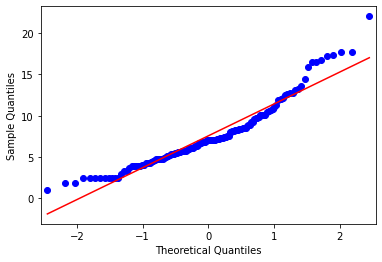

c:\users\jeroe\pycharmprojects\aihackcovid\venv\lib\site-packages\statsmodels\graphics\gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


c:\users\jeroe\pycharmprojects\aihackcovid\venv\lib\site-packages\statsmodels\graphics\gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


The data can be considered normally distributed.


In [49]:
'''
Verify normal distribution with, for example, a q-q plot, which
compares our data with a Gaussian distribution (or normal distribution)
'''
from statsmodels.graphics.gofplots import qqplot
from matplotlib import pyplot

# q-q plot
qqplot(df_bis['diabetes_prevalence'], line='s')
pyplot.show()

qqplot(df_bis['cvd_rate'], line='s')
pyplot.show()

qqplot(df_bis['n_smokers'], line='s')
pyplot.show()

print('The data can be considered normally distributed.')

In [50]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import numpy as np

y = np.log(df_bis['total_deaths'])
x = df_bis[['diabetes_prevalence', 'cvd_rate', 'n_smokers']]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)

# define model
linear_regression = LinearRegression()

# fitting the model
linear_regression.fit(x_train,y_train)

print(linear_regression.intercept_)
print(linear_regression.coef_)

# predict with the data
y_pred = linear_regression.predict(x_test)

print()
print('Actual values:')
display(y_test)
print()
print('Predicted values:')
display(y_pred[0:8])

7.249826452738661
[-0.0086038  -0.00418358  0.03550622]

Actual values:


     country         
8    Bahamas              5.278115
90   Niger                5.252273
120  Tanzania             3.044522
109  Sierra Leone         4.369448
27   Comoros              4.983607
101  Qatar                6.035481
60   Italy               11.687055
96   Papua New Guinea     4.624973
113  South Africa        10.899051
121  Thailand             4.859812
26   Colombia            11.168828
89   New Zealand          3.258097
24   Chile               10.155879
110  Singapore            3.401197
91   Nigeria              7.630947
59   Israel               8.756210
135  World               14.946741
51   Greece               9.205328
119  Switzerland          9.268043
106  Senegal              7.002156
33   Czechia             10.272289
22   Canada              10.082136
2    Andorra              4.820282
118  Sweden               9.541297
62   Japan                9.199279
18   Brunei               1.098612
10   Bangladesh           9.301277
54   Iceland              3.36729


Predicted values:


array([6.98377864, 6.78224194, 7.35649992, 7.64518769, 7.04771492,
       7.35201756, 8.42542025, 7.31601519])

In [51]:
import seaborn as sb

sb.regplot(x=y_test, y=y_pred, ci=None, color="b")

<AxesSubplot:xlabel='total_deaths'>

We get an anedoctal result - the line shows underfitting. Still, the claim can be made, that based on this model and the data, there is a positive influence of the three variables in the total number of Covid-19 caused deaths worldwide, that is, cardiovasculary disease, diabetes and smoking.